In [1]:
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt

# Data Pre-Processing function

In [2]:
def filter_event(event, btag_cols=[], lepton_cols=[]):
    """
    This function verifies if a given event is to be filtered
    Every event should have at least 2 leptons and 1 btag. If it fails
    to meet these criteria, it is filtered
    
    event -> pandas dataframe entry: the event to be verified
    btag_cols -> [string]: list of columns referring to btag count
    lepton_cols -> [string]: list of columns referring to lepton count
    
    return -> Bool: True if event is to be filtered, False otherwise
    """

    # Calculate number of btags and leptons
    btag_count = sum([event[col] for col in btag_cols])
    lepton_count = sum([event[col] for col in lepton_cols])
    
    return btag_count < 1 or lepton_count < 2


def process_data(data_path, del_cols=[], btag_cols=[], lepton_cols=[]):
    """
    This functions reads and pre-processes all the data in the chosen data_path with pandas
    
    data_path -> string: the path of the data to be acquired and pre-processed
    del_cols -> [string]: all columns to be deleted from the dataframe
    btag_cols -> [string]: list of columns referring to btag count
    lepton_cols -> [string]: list of columns referring to lepton count
    
    return -> pandas dataframe: pre-processed data
    """
    
    # Initializing variables
    data = []
    total_drop, total_len = 0, 0
    files = glob(data_path + "/*.csv")
    files += glob(data_path + "/*.h5")
    
    # Collect all data from path
    for file in tqdm(files, total=len(files), desc="Preprocessing Data"):
        # Read sample
        if file.endswith(".csv"): df = pd.read_csv(file)
        elif file_format == "h5": df = pd.read_hdf(file)
        else: raise ValueError("Unrecognized file format")
            
        # Sort indices
        df.sort_index(inplace=True)
        
        # Apply cuts
        drop_list = [i for i in range(df.shape[0]) if filter_event(df.loc[i], btag_cols, lepton_cols)]
        tqdm.write(f"File: {file} | Original Size: {len(df)} | Drop_Ratio: {len(drop_list)/len(df):.3f}")
        total_drop, total_len = total_drop + len(drop_list), total_len + df.shape[0]
        df.drop(drop_list, inplace=True)
        
        # Delete columns
        df.drop([col for col in del_cols if col in df], axis=1, inplace=True)
        
        # Calculate gen_weights
        df["gen_xsec"] = df["gen_xsec"].mean() / df.shape[0]
        df.rename(columns={"gen_xsec":"gen_weights"}, inplace=True)
        
        # Add sample and label columns
        if file.split("/")[-2] == "dileptonic": df["Label"] = 0
        elif file.split("/")[-2] == "sm_gluon_vlq": df["Label"] = 1
        else: raise ValueError("Unrecognized data folder")
        sample = file.split("/")[-1].split(".")[0]
        df["Sample"] = sample
        
        data.append(df)
        
    # Concatenate data
    if len(data) > 1: data = pd.concat(data)
    else: data = data[0]
        
    print(f"Total Drop Ratio: {total_drop/total_len:.3f}")
        
    return data

# Import Data

In [3]:
# Delete, Btag and Lepton columns
del_cols = ["gen_decay1", "gen_decay2", "gen_sample", "gen_filter", "gen_decay_filter", "MissingET_Eta"]
btag_cols = ["Jet1_BTag", "Jet2_BTag", "Jet3_BTag", "Jet4_BTag", "Jet5_BTag"]
lepton_cols = ["Electron_Multi", "Muon_Multi"]

In [4]:
# PreProcess bkgd data
data_path = "data/dileptonic"
bkgd = process_data(data_path, del_cols, btag_cols, lepton_cols)
bkgd

Preprocessing Data:   6%|▌         | 1/18 [00:11<03:21, 11.85s/it]

File: data/dileptonic/ttbarZ_2L.csv | Original Size: 100000 | Drop_Ratio: 0.584


Preprocessing Data:   6%|▌         | 1/18 [08:09<03:21, 11.85s/it]

File: data/dileptonic/Zbj_2L.csv | Original Size: 4000000 | Drop_Ratio: 0.788


Preprocessing Data:  11%|█         | 2/18 [16:03<40:26, 151.67s/it]

File: data/dileptonic/Zbb_2L.csv | Original Size: 4000000 | Drop_Ratio: 0.899


Preprocessing Data:  17%|█▋        | 3/18 [24:02<1:02:08, 248.57s/it]

File: data/dileptonic/Zjj_2L.csv | Original Size: 4000000 | Drop_Ratio: 0.978


Preprocessing Data:  28%|██▊       | 5/18 [25:02<52:03, 240.26s/it]  

File: data/dileptonic/ZZ_2L.csv | Original Size: 500000 | Drop_Ratio: 0.948


Preprocessing Data:  33%|███▎      | 6/18 [25:08<33:59, 169.97s/it]

File: data/dileptonic/ttbarZ_2L_test.csv | Original Size: 50000 | Drop_Ratio: 0.585


Preprocessing Data:  39%|███▉      | 7/18 [25:14<22:08, 120.80s/it]

File: data/dileptonic/topZj_2L_test.csv | Original Size: 50000 | Drop_Ratio: 0.694


Preprocessing Data:  44%|████▍     | 8/18 [25:20<14:23, 86.39s/it] 

File: data/dileptonic/topWZ_2L.csv | Original Size: 50000 | Drop_Ratio: 0.626


Preprocessing Data:  50%|█████     | 9/18 [25:26<09:20, 62.27s/it]

File: data/dileptonic/topZj_2L_train.csv | Original Size: 50000 | Drop_Ratio: 0.691


Preprocessing Data:  56%|█████▌    | 10/18 [25:38<06:17, 47.15s/it]

File: data/dileptonic/ttbarW_2L.csv | Original Size: 100000 | Drop_Ratio: 0.668


Preprocessing Data:  61%|██████    | 11/18 [25:50<04:16, 36.59s/it]

File: data/dileptonic/topZj_2L.csv | Original Size: 100000 | Drop_Ratio: 0.693


Preprocessing Data:  67%|██████▋   | 12/18 [26:50<04:21, 43.62s/it]

File: data/dileptonic/WZ_2L.csv | Original Size: 500000 | Drop_Ratio: 0.977


Preprocessing Data:  67%|██████▋   | 12/18 [34:38<04:21, 43.62s/it]

File: data/dileptonic/ttbarb_2L.csv | Original Size: 3899999 | Drop_Ratio: 0.690


Preprocessing Data:  78%|███████▊  | 14/18 [34:45<08:06, 121.60s/it]

File: data/dileptonic/ttbarZ_2L_train.csv | Original Size: 50000 | Drop_Ratio: 0.584


Preprocessing Data:  83%|████████▎ | 15/18 [35:45<05:09, 103.15s/it]

File: data/dileptonic/ttbarH_2L.csv | Original Size: 500000 | Drop_Ratio: 0.698


Preprocessing Data:  89%|████████▉ | 16/18 [36:46<03:01, 90.51s/it] 

File: data/dileptonic/ttbar_2L.csv | Original Size: 500000 | Drop_Ratio: 0.694


Preprocessing Data:  89%|████████▉ | 16/18 [44:45<03:01, 90.51s/it]

File: data/dileptonic/ttbarj_2L.csv | Original Size: 4000000 | Drop_Ratio: 0.712


Preprocessing Data: 100%|██████████| 18/18 [45:44<00:00, 152.49s/it]


File: data/dileptonic/WW_2L.csv | Original Size: 500000 | Drop_Ratio: 0.994
Total Drop Ratio: 0.815


,FatJet_Multi,FatJet1_PT,FatJet2_PT,FatJet3_PT,FatJet4_PT,FatJet5_PT,FatJet1_Mass,FatJet2_Mass,FatJet3_Mass,FatJet4_Mass,...,Electron1_Eta,Electron2_Eta,Electron1_Phi,Electron2_Phi,MissingET_MET,MissingET_Phi,ScalarHT_HT,gen_weights,Label,Sample
0,0,0.000000,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,60.960083,1.906941,494.328735,9.665701e-07,0,ttbarZ_2L
1,0,0.000000,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,68.370354,-0.644279,304.370178,9.665701e-07,0,ttbarZ_2L
2,0,0.000000,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,34.932068,-0.817430,497.313385,9.665701e-07,0,ttbarZ_2L
5,0,0.000000,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,...,-0.838820,-1.251187,-2.780355,1.185138,264.651123,-0.003040,511.396637,9.665701e-07,0,ttbarZ_2L
6,1,222.386703,0.0,0.0,0.0,0.0,89.2817,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,74.745476,-2.622154,646.912720,9.665701e-07,0,ttbarZ_2L
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499169,0,0.000000,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,127.361801,0.185474,253.819656,1.137059e-03,0,WW_2L
499182,0,0.000000,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,96.348442,-1.346854,449.474792,1.137059e-03,0,WW_2L
499281,0,0.000000,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,...,-1.844197,0.000000,2.360979,0.000000,112.914993,-0.001153,143.338226,1.137059e-03,0,WW_2L
499428,0,0.000000,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,100.695595,0.774737,442.551941,1.137059e-03,0,WW_2L


In [5]:
#Pre-Process VLQ data
data_path = "data/sm_gluon_vlq"
vlq = process_data(data_path, del_cols, btag_cols, lepton_cols)
vlq

Preprocessing Data:  14%|█▍        | 1/7 [00:30<03:00, 30.02s/it]

File: data/sm_gluon_vlq/mch45_HG_13TeV_wohg_HQ1200_test.csv | Original Size: 250000 | Drop_Ratio: 0.947


Preprocessing Data:  29%|██▊       | 2/7 [01:00<02:30, 30.06s/it]

File: data/sm_gluon_vlq/mch45_HG_13TeV_wohg_HQ1200_train.csv | Original Size: 250000 | Drop_Ratio: 0.948


Preprocessing Data:  43%|████▎     | 3/7 [01:30<02:00, 30.20s/it]

File: data/sm_gluon_vlq/mch45_HG_13TeV_wohg_HQ1400_train.csv | Original Size: 250000 | Drop_Ratio: 0.950


Preprocessing Data:  57%|█████▋    | 4/7 [05:20<04:30, 90.18s/it]

File: data/sm_gluon_vlq/smg.csv | Original Size: 1900000 | Drop_Ratio: 0.944


Preprocessing Data:  71%|███████▏  | 5/7 [05:50<02:24, 72.16s/it]

File: data/sm_gluon_vlq/mch45_HG_13TeV_wohg_HQ1000_test.csv | Original Size: 250000 | Drop_Ratio: 0.943


Preprocessing Data:  86%|████████▌ | 6/7 [06:21<00:59, 59.54s/it]

File: data/sm_gluon_vlq/mch45_HG_13TeV_wohg_HQ1000_train.csv | Original Size: 250000 | Drop_Ratio: 0.944


Preprocessing Data: 100%|██████████| 7/7 [06:51<00:00, 58.73s/it]

File: data/sm_gluon_vlq/mch45_HG_13TeV_wohg_HQ1400_test.csv | Original Size: 250000 | Drop_Ratio: 0.951
Total Drop Ratio: 0.945


,FatJet_Multi,FatJet1_PT,FatJet2_PT,FatJet3_PT,FatJet4_PT,FatJet5_PT,FatJet1_Mass,FatJet2_Mass,FatJet3_Mass,FatJet4_Mass,...,Electron1_Eta,Electron2_Eta,Electron1_Phi,Electron2_Phi,MissingET_MET,MissingET_Phi,ScalarHT_HT,gen_weights,Label,Sample
8,4,679.288574,637.196655,575.872986,465.836670,0.000000,237.651794,84.461655,95.651817,168.446136,...,1.093419,0.041427,-2.275989,3.101779,59.826347,-1.571166,2314.953613,6.340193e-07,1,mch45_HG_13TeV_wohg_HQ1200_test
72,3,722.096008,712.639893,292.318909,0.000000,0.000000,95.335800,268.030182,64.672127,0.000000,...,-1.049473,0.000000,-0.830934,0.000000,854.150696,-1.032758,1928.374756,6.340193e-07,1,mch45_HG_13TeV_wohg_HQ1200_test
82,3,630.115234,305.956909,283.162201,0.000000,0.000000,114.620941,91.065170,96.998154,0.000000,...,0.621256,0.000000,1.390831,0.000000,701.605103,-2.040793,1302.086548,6.340193e-07,1,mch45_HG_13TeV_wohg_HQ1200_test
115,3,615.789185,381.363312,289.322754,0.000000,0.000000,157.678223,123.475723,64.592873,0.000000,...,-0.639307,0.000000,2.483285,0.000000,377.781586,1.851912,1421.504761,6.340193e-07,1,mch45_HG_13TeV_wohg_HQ1200_test
118,2,603.029968,528.326599,0.000000,0.000000,0.000000,96.925636,119.643799,0.000000,0.000000,...,0.418918,0.109304,2.743015,2.692961,185.340561,-0.824091,1783.073975,6.340193e-07,1,mch45_HG_13TeV_wohg_HQ1200_test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249910,4,666.686401,607.264709,450.049072,391.603912,0.000000,115.184601,179.727097,114.864006,64.223465,...,0.000000,0.000000,0.000000,0.000000,112.573494,-2.934912,2303.999756,2.099393e-07,1,mch45_HG_13TeV_wohg_HQ1400_test
249918,4,928.090820,700.795898,401.137665,232.056839,0.000000,346.194672,102.790993,94.033356,23.929482,...,0.000000,0.000000,0.000000,0.000000,365.781525,-2.217049,2508.777588,2.099393e-07,1,mch45_HG_13TeV_wohg_HQ1400_test
249942,2,1385.916504,1031.829224,0.000000,0.000000,0.000000,139.179977,158.596802,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,226.095474,-0.110796,2874.203857,2.099393e-07,1,mch45_HG_13TeV_wohg_HQ1400_test
249974,5,967.123413,555.906433,533.325867,327.264191,263.725922,173.991745,96.630959,131.944000,63.603821,...,0.000000,0.000000,0.000000,0.000000,329.906006,0.181167,2831.758057,2.099393e-07,1,mch45_HG_13TeV_wohg_HQ1400_test


In [6]:
bkgd.describe()

,FatJet_Multi,FatJet1_PT,FatJet2_PT,FatJet3_PT,FatJet4_PT,FatJet5_PT,FatJet1_Mass,FatJet2_Mass,FatJet3_Mass,FatJet4_Mass,...,Electron2_PT,Electron1_Eta,Electron2_Eta,Electron1_Phi,Electron2_Phi,MissingET_MET,MissingET_Phi,ScalarHT_HT,gen_weights,Label
count,4.245075e+06,4.245075e+06,4.245075e+06,4.245075e+06,4.245075e+06,4.245075e+06,4.245075e+06,4.245075e+06,4.245075e+06,4.245075e+06,...,4.245075e+06,4.245075e+06,4.245075e+06,4.245075e+06,4.245075e+06,4.245075e+06,4.245075e+06,4.245075e+06,4.245075e+06,4245075.0
mean,1.483439e-01,3.065015e+01,8.810914e+00,1.000308e+00,8.996476e-02,6.142012e-03,7.257056e+00,2.049691e+00,2.162871e-01,1.819566e-02,...,9.697738e+00,1.144244e-04,6.578391e-05,1.084335e-03,1.264110e-05,5.632488e+01,-9.000460e-04,3.605171e+02,1.113686e-04,0.0
std,4.600027e-01,9.142469e+01,4.937019e+01,1.601084e+01,4.676777e+00,1.191221e+00,2.411029e+01,1.293754e+01,3.931916e+00,1.074299e+00,...,2.003727e+01,8.418525e-01,5.749829e-01,1.370063e+00,9.116318e-01,4.660419e+01,1.813783e+00,1.834634e+02,5.202477e-04,0.0
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-5.285799e-05,-2.642900e-05,-1.525879e-05,-5.394797e-06,...,0.000000e+00,-2.499997e+00,-2.499985e+00,-3.141592e+00,-3.141592e+00,2.363494e-02,-3.141591e+00,4.447565e+01,1.304437e-07,0.0
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,-1.928962e-01,0.000000e+00,-3.839418e-01,0.000000e+00,1.898484e+01,-1.571305e+00,2.310312e+02,5.842474e-07,0.0
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.528167e+01,-3.040939e-03,3.254956e+02,2.374618e-05,0.0
75%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.121624e+01,1.953454e-01,0.000000e+00,3.898618e-01,0.000000e+00,8.197744e+01,1.569735e+00,4.480336e+02,2.458480e-05,0.0
max,6.000000e+00,1.723009e+03,1.671709e+03,7.519292e+02,4.521231e+02,3.006590e+02,5.243948e+02,5.052833e+02,3.052442e+02,1.789616e+02,...,5.076544e+02,2.499979e+00,2.499981e+00,3.141593e+00,3.141575e+00,9.765567e+02,3.141591e+00,3.903838e+03,3.651510e-03,0.0


In [7]:
vlq.describe()

,FatJet_Multi,FatJet1_PT,FatJet2_PT,FatJet3_PT,FatJet4_PT,FatJet5_PT,FatJet1_Mass,FatJet2_Mass,FatJet3_Mass,FatJet4_Mass,...,Electron2_PT,Electron1_Eta,Electron2_Eta,Electron1_Phi,Electron2_Phi,MissingET_MET,MissingET_Phi,ScalarHT_HT,gen_weights,Label
count,186417.000000,186417.000000,186417.000000,186417.000000,186417.000000,186417.000000,186417.000000,186417.000000,186417.000000,186417.000000,...,186417.000000,186417.000000,186417.000000,186417.000000,186417.000000,186417.000000,186417.000000,186417.000000,1.864170e+05,186417.0
mean,3.029064,675.879484,478.395744,263.448840,91.028366,10.464728,144.010754,108.693549,63.154146,21.015445,...,39.248399,-0.001527,-0.000076,0.000423,-0.003310,241.024070,0.001392,1762.749973,6.223814e-07,1.0
std,0.934578,242.733984,214.605885,189.968086,144.648688,52.451235,75.660887,60.367382,54.152196,37.759748,...,80.538525,0.703948,0.525127,1.373439,1.014874,187.853533,1.814357,559.753229,6.726744e-07,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000031,-0.000053,-0.000026,-0.000015,...,0.000000,-2.499892,-2.498925,-3.141591,-3.141527,0.025636,-3.141589,166.685715,2.066960e-07,1.0
25%,2.000000,509.685059,348.811218,0.000000,0.000000,0.000000,95.147530,77.239761,0.000000,0.000000,...,0.000000,-0.165557,0.000000,-0.401599,0.000000,99.808525,-1.570896,1374.090454,3.019152e-07,1.0
50%,3.000000,641.134888,458.433594,287.140656,0.000000,0.000000,124.228271,100.849373,65.293747,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,194.896317,-0.002699,1702.707520,3.019152e-07,1.0
75%,4.000000,805.391113,592.543335,389.300476,223.438263,0.000000,174.710190,138.641495,98.317261,31.088343,...,40.312710,0.154997,0.000000,0.415547,0.000000,333.532501,1.579292,2079.789795,6.340193e-07,1.0
max,8.000000,2675.347900,2265.266357,1248.350830,1062.891113,814.843140,1065.849609,842.915161,543.557068,337.304260,...,990.969849,2.499868,2.498529,3.141592,3.141411,2279.300049,3.141547,6155.838379,2.202083e-06,1.0


# Plots

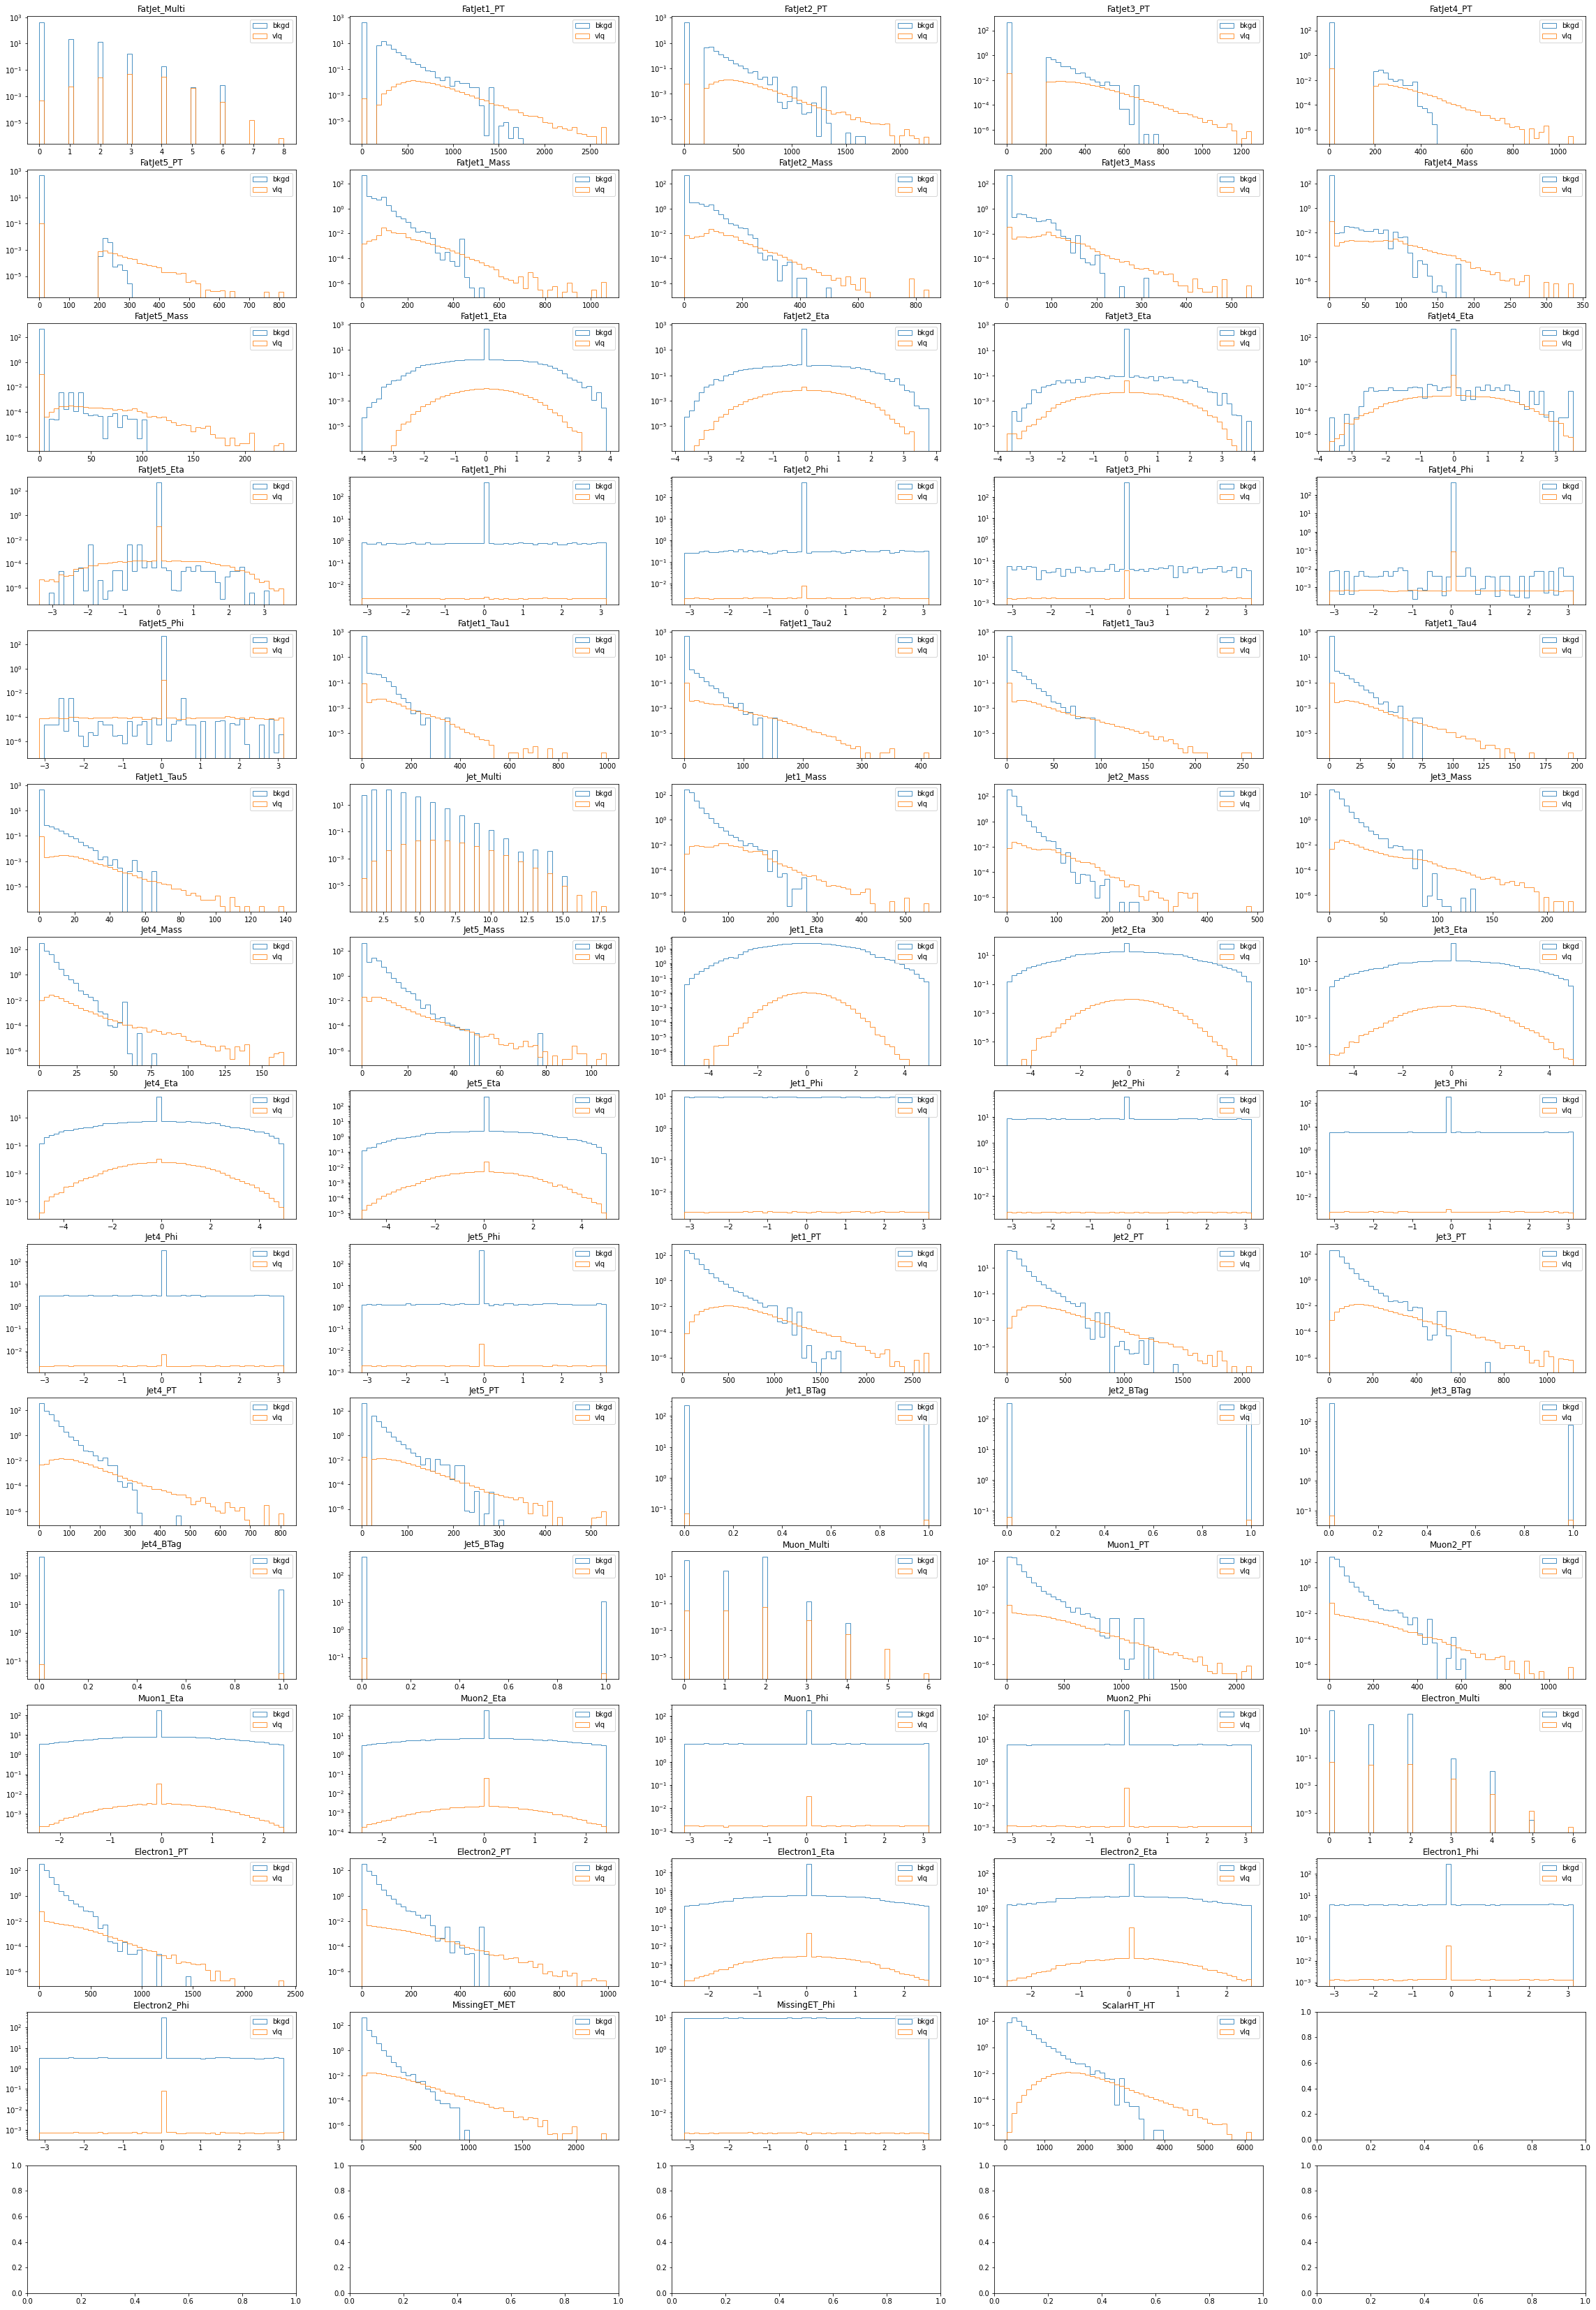

In [11]:
# Create plots
num_rows = int(np.ceil((len(list(bkgd.columns)) - 2) / num_cols))
fig, axs = plt.subplots(num_rows, num_cols, figsize=(40, 60))

# Adjustment variables
num_cols, bins = 5, 50

# Iterate and plot the data
ignore_cols = ["gen_weights", "Label", "Sample"]
for i, column in enumerate(bkgd.columns):
    if vlq.columns[i] not in ignore_cols:
        # Define histogram range
        hist_min = min(vlq[column].min(), bkgd[column].min())
        hist_max = max(vlq[column].max(), bkgd[column].max())
        hist_range = (hist_min, hist_max)

        # Plot data
        row, col = int(i/num_cols), i%num_cols
        axs[row, col].set_title(vlq.columns[i])
        axs[row, col].hist(bkgd[column], bins=50, label="bkgd", alpha=0.8, range=hist_range,
                           weights=bkgd["gen_weights"], histtype='step')
        axs[row, col].hist(vlq[column], bins=50, label="vlq", alpha=0.8, range=hist_range,
                           weights=vlq["gen_weights"], histtype='step')
        axs[row, col].set_yscale("log")
        axs[row, col].legend()

plt.show()